In [349]:
import numpy as np
import scipy as sp
import torch as th

import os, pdb, sys, json, glob, tqdm
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

sns.set_context('notebook')

%matplotlib notebook
plt.rcParams['figure.figsize'] = [5,5]
plt.rcParams['figure.dpi'] = 200
# %config InlineBackend.figure_format ='retina'

dev = 'cpu'
from runner import get_data

In [350]:
loc = 'inpca_results'

In [3]:
def create_torun():
    ngpus=4
    ccs = []
    i = 0
    for widen in [2,4]:
        for numc in [2,4,8]:
            for seed in range(42, 200):
                cc = 'CUDA_VISIBLE_DEVICES=%d python runner.py --seed %d --numc %d --widen %d'%(i%ngpus, seed, numc, widen)
                ccs.append(cc)
                i += 1
                if i % (ngpus) == 0:
                    ccs = ccs + ['sleep 30']*ngpus
    with open('torun.txt', 'w') as fp:
        for c in ccs:
            fp.write(c+'\n')

In [4]:
ds = get_data()

In [ ]:
r = []
for f in glob.glob(os.path.join(loc, 'models', '*.p')):
    k = json.loads(f[21:-2])
    d = th.load(f)
    for i in range(len(d)):
        t = {}
        t.update(k)
        t.update({'t': i})
        t.update(d[i])
#         if t['widen'] == 2 and t['numc'] == 2:
        r.append(t)

In [ ]:
d = pd.DataFrame(r)
d['err'] = d.apply(lambda r: r.e.mean().item(), axis=1)
d['verr'] = d.apply(lambda r: r.ev.mean().item(), axis=1)
d['favg'] = d.apply(lambda r: r.f.mean().item(), axis=1)
d['vfavg'] = d.apply(lambda r: r.fv.mean().item(), axis=1)

print(d.keys(), len(d))
del r

In [5]:
# th.save(d,'d.p')
d = th.load(os.path.join(loc,'d.p'))
# d22 = th.load('d_2_2.p')

### Embed the models into a feature space

In [6]:
def get_idx(dd, cond):
    return dd.query(cond).index.tolist()

def embed(dd, fn='', ss=1, ne=3, key='yh', force=False):
    dc = dd[['seed', 'widen', 'numc', 't', 'err', 'verr', 'favg', 'vfavg']]
    th.save(dc, os.path.join(loc,'didx_%s.p'%fn))
    x = np.array([dd.iloc[i][key][::ss].float().numpy() for i in range(len(dd))])
    n = x.shape[0]

    if (not os.path.isfile(os.path.join(loc,'w_%s.p'%fn))) or force:
        a = np.sqrt(np.exp(x))
        a = np.moveaxis(a, 0, 1)
        w = np.zeros((n,n))
        nc = 100 if n < 4000 else 200
        print('chunks: ', nc)
        for aa in tqdm.tqdm(np.split(a, nc)):
            w += np.log(np.einsum('kil,kjl->kij', aa, aa, optimize=True)).sum(0)
        w = -w

        del a
        l = np.eye(w.shape[0]) - 1.0/w.shape[0]
        w = l @ w @ l
        print('Saving w')
        th.save(w, os.path.join(loc,'w_%s.p'%fn))
    else:
        print('Found: ', os.path.join(loc,'w_%s.p'%fn))

    w = th.load(os.path.join(loc,'w_%s.p'%fn))
    print('Projecting')
    e1,v1 = sp.linalg.eigh(w, driver='evx', check_finite=False,
                        subset_by_index=[n-(ne+1),n-1])
    e2,v2 = sp.linalg.eigh(w, driver='evx', check_finite=False,
                        subset_by_index=[0,(ne+1)])
    e = np.concatenate((e1,e2))
    v = np.concatenate((v1,v2), axis=1)

    ii = np.argsort(np.abs(e))[::-1]
    e,v = e[ii], v[:,ii]
    xp = v*np.sqrt(np.abs(e))
    r = dict(xp=xp,w=w,e=e,v=v)
    th.save(r, os.path.join(loc,'r_%s.p'%fn))
    return

In [ ]:
r = embed(d, fn='v_full', ss=2, key='yvh')

In [ ]:
# r22 = embed(d22, ss=10)
for numc in [4,8]:
    for widen in [4]:
        dd = d[(d['widen']==widen) & (d['numc']==numc)]
        fn = 'v_widen_%d_numc_%d'%(widen, numc)
        print('widen %d, numc %d'%(widen, numc))
        r = embed(dd, fn=fn, ss=2, key= 'yvh', force=True)

<IPython.core.display.Javascript object>


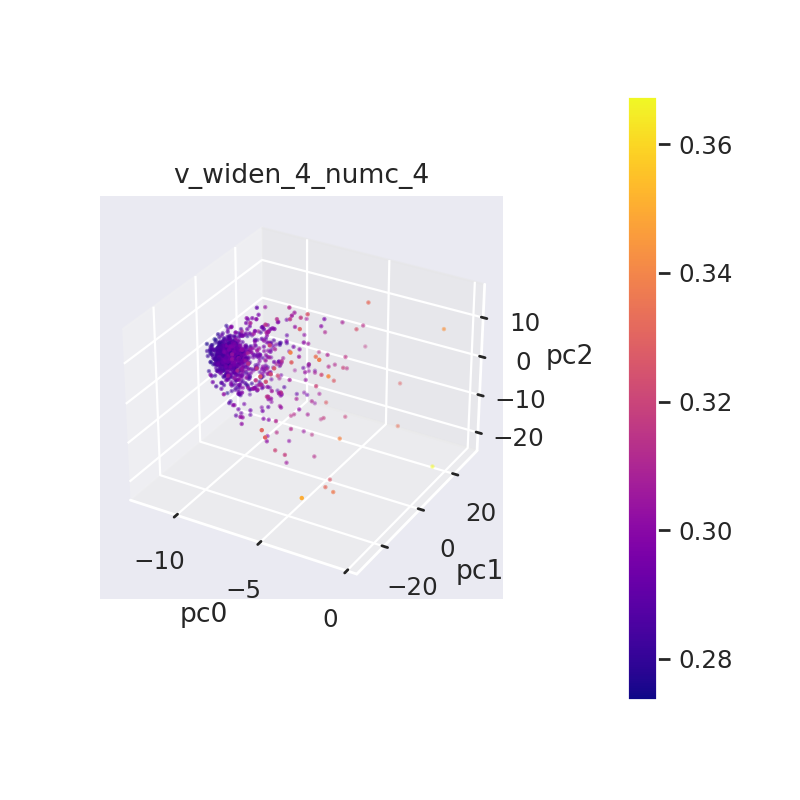

In [348]:
widen,numc=4,4
fn = 'v_widen_%d_numc_%d'%(widen,numc)

r = th.load(os.path.join(loc,'r_%s.p'%fn))
dc = th.load(os.path.join(loc,'didx_%s.p'%fn)).reset_index()

get_idx = lambda c: dc.query(c).index.tolist()

ii = get_idx('t > 2 & widen == 4 & numc == 4')
xx = r['xp'][ii]
ee = r['e']
# print(ee[:3])
c = dc['verr'][ii]

fig = plt.figure(10)
plt.clf();
ax = fig.add_subplot(projection='3d')
sc = ax.scatter(xx[:,0], xx[:,1], xx[:,2],
                c=c, s=1, cmap='plasma')
ax.set_xlabel('pc0'); ax.set_ylabel('pc1'); ax.set_zlabel('pc2');
plt.colorbar(sc, pad=0.2);
plt.title(fn);

In [365]:
# widen,numc=4,4
# fn = 'widen_%d_numc_%d'%(widen,numc)
fn = 'full'

r = th.load(os.path.join(loc,'r_%s.p'%fn))
dc = th.load(os.path.join(loc,'didx_%s.p'%fn)).reset_index()

get_idx = lambda c: dc.query(c).index.tolist()

In [344]:
jj = get_idx('t == 9 & widen == 4 & numc == 4')
dd = d.loc[jj]
t = th.stack([th.sum(th.exp(-d.loc[j].fv)*d.loc[j].fv, dim=-1) for j in jj]).squeeze()
yidx_prototypes = t.mean(0).argsort(descending=True)[:1000]

ee = th.stack([d.loc[j].ev for j in jj])

In [345]:
print(ee[:,yidx_prototypes].mean(1))
print(t)

tensor([0.5180, 0.5460, 0.5180, 0.5360, 0.5560, 0.5180, 0.5180, 0.5300, 0.5400,
        0.5330, 0.5280, 0.4880, 0.5550, 0.5220, 0.5360, 0.5320, 0.5250, 0.5300,
        0.5360, 0.5370, 0.5120, 0.5140, 0.5450, 0.4960, 0.5480, 0.5220, 0.5390,
        0.5450, 0.5190, 0.5260, 0.5100, 0.5350, 0.5380, 0.5380, 0.5350, 0.5420,
        0.5240, 0.5420, 0.5150, 0.5240, 0.5400, 0.5280, 0.5390, 0.5180, 0.5740,
        0.5150, 0.5470, 0.5080, 0.5710, 0.5490, 0.5090, 0.5250, 0.5120, 0.5150,
        0.5540, 0.5360, 0.5410, 0.5360, 0.5170, 0.5140, 0.5400, 0.5460, 0.5170,
        0.5370, 0.5240, 0.5190, 0.5410, 0.5480, 0.5590, 0.5190, 0.5410, 0.5350,
        0.5530, 0.5330, 0.5550, 0.5390, 0.5370, 0.5180, 0.5370, 0.5300, 0.5470,
        0.5130, 0.5410, 0.5150, 0.5110, 0.5410, 0.5370, 0.5440, 0.5440, 0.5240,
        0.5460, 0.5190, 0.5630, 0.5280, 0.5350, 0.5200, 0.5430, 0.5360, 0.5280,
        0.5090, 0.5300, 0.5350, 0.5070, 0.5480, 0.5030, 0.5300, 0.5590, 0.5220,
        0.5280, 0.5160, 0.5250, 0.5280, 

<IPython.core.display.Javascript object>


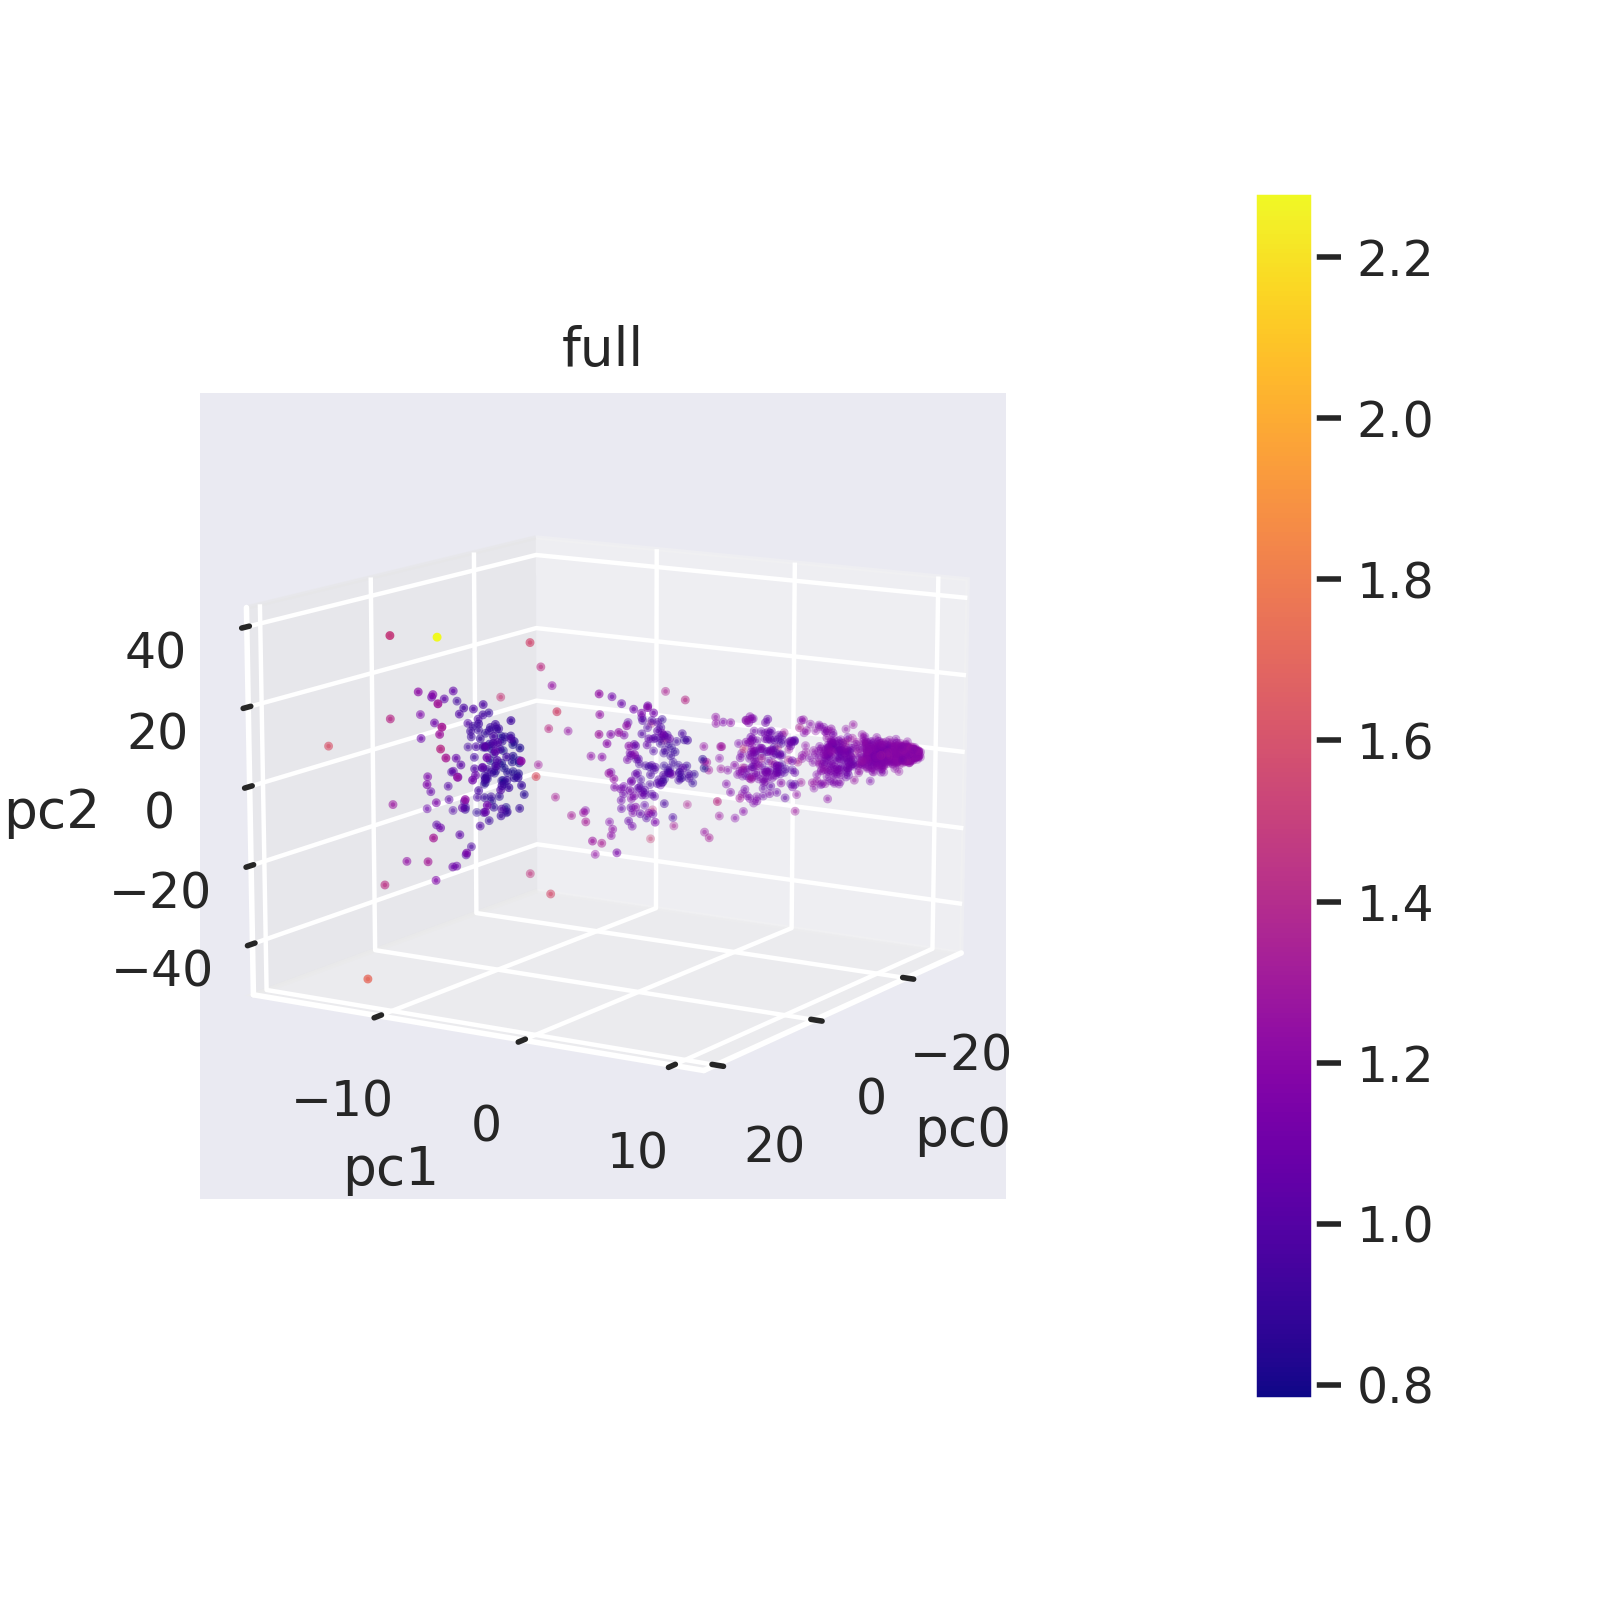

In [369]:
ii = get_idx('t >= 1 & widen == 4 & numc == 4')
xx = r['xp'][ii]
ee = r['e']
# print(ee[:3])
c = dc['vfavg'][ii]
# c = [d.loc[i].ev[yidx_prototypes].mean().item() for i in ii]

fig = plt.figure(1)
plt.clf();
ax = fig.add_subplot(projection='3d')
sc = ax.scatter(xx[:,0], xx[:,1], xx[:,2],
                c=c, s=1, cmap='plasma')
ax.set_xlabel('pc0'); ax.set_ylabel('pc1'); ax.set_zlabel('pc2');
plt.colorbar(sc, pad=0.2);
plt.title(fn);

In [298]:
dc

,index,seed,widen,numc,t,err,verr,favg,vfavg
0,0,182,4,4,0,0.90240,0.9021,2.309040,2.308951
1,1,182,4,4,1,0.24216,0.3285,0.677591,0.974643
2,2,182,4,4,2,0.16564,0.3131,0.432082,1.071076
3,3,182,4,4,3,0.04704,0.2849,0.161178,1.012671
4,4,182,4,4,4,0.03964,0.3002,0.126420,1.150054
...,...,...,...,...,...,...,...,...,...
9475,9475,150,4,8,5,0.00000,0.2280,0.001845,0.969538
9476,9476,150,4,8,6,0.00000,0.2263,0.001254,0.978492
9477,9477,150,4,8,7,0.00000,0.2295,0.001258,0.987921
9478,9478,150,4,8,8,0.00000,0.2277,0.001107,0.993416
